# **PROBLEMA DE NEGOCIO**


---




## Una tienda online de moda, con presencia en todo Brasil, necesita impulsar su rendimiento utilizando sus datos de manera estratégica. Como científico de datos, has sido convocado para analizar estos datos y ofrecer insights que guíen sus decisiones y respondan a las siguientes preguntas clave:

### **Preguntas**

1. ¿Cual es el Top 5 productos más vendidos históricamente?

2. ¿Cual es la evolución histórica de las ingresos netos?

3. ¿Cuáles son los ingresos netos por vendedor por año?

4. ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?

5. ¿Existe otro insight que puedas proporcionar?

# **1. Configuración del Ambiente**


---




In [1]:
# pip install geobr

In [2]:

import  geobr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import matplotlib.image as image
import requests
from io import BytesIO
from sqlalchemy import create_engine, MetaData, Table, inspect, text
import plotly.express as px
from PIL import Image  # Importamos PIL para trabajar con imágenes
import os  # Importamos os para trabajar con rutas de archivos y directorios
from matplotlib.colors import LinearSegmentedColormap
from urllib.request import urlretrieve
global df_itens_pedidos, df_pedidos, df_productos, df_vendedores, database


# **2. Obtención, Tratamiento y Análisis Exploratório (EDA)**


---




## **2.1 Cargando las bases de datos**

In [3]:
df_itens_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/itens_pedidos.csv')
df_itens_pedidos.head()

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,ciudad,costo_envio
0,1,41518,341,3,260,780,BR-BA,156.0
1,2,4307,1174,5,6175,30875,BR-RJ,6175.0
2,3,22407,1399,3,200,600,BR-PB,120.0
3,4,3820,1652,6,139,834,BR-DF,166.8
4,5,29012,2470,3,525,1575,BR-BA,315.0


In [4]:
df_pedidos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/pedidos.csv')
df_pedidos.head()

,pedido_id,producto_id,vendedor_id,fecha_compra,total
0,341,41518,6,2019-01-05,780
1,1174,4307,3,2019-01-05,30875
2,1399,22407,1,2019-01-05,600
3,1652,3820,4,2019-01-05,834
4,2470,29012,2,2019-01-05,1575


In [5]:
df_productos = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/productos.csv')
df_productos.head()

,producto_id,producto,precio,marca,sku,condicion
0,21244,Oculos Lente Azulada,1120,D&g Dolce & Gabbana,209297.0,Usado
1,9981,Bolsa Coral Saco,4000,Givenchy,278612.0,Usado
2,84176,Camisa Xadrez Verde,310,Joe Fresh,322482.0,Usado
3,47475,Calca Alfaiataria Preta,490,Mixed,263658.0,Usado
4,74864,Vestido Jeans Babados,130,Zara,219248.0,Usado


In [6]:
df_vendedores = pd.read_csv('https://raw.githubusercontent.com/ElProfeAlejo/Bootcamp_Databases/main/vendedores.csv')
df_vendedores.head()

,vendedor_id,nombre_vendedor
0,1,Ana Duarte
1,2,Daniel Siqueira
2,3,Nadia Oliveira
3,4,Millena Pereira
4,5,Paulo Calanca


## **2.2 Tratamiento de Datos**

In [7]:
print(df_itens_pedidos.info())
print('-------------')
print(df_pedidos.info())
print('-------------')
print(df_productos.info())
print('-------------')
print(df_vendedores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   pedido_id     24527 non-null  int64 
 1   producto_id   24527 non-null  int64 
 2   vendedor_id   24527 non-null  int64 
 3   fecha_compra  24527 non-null  object
 

In [8]:
df_productos.isna().sum()

producto_id    0
producto       2
precio         0
marca          0
sku            2
condicion      0
dtype: int64

In [9]:
df_productos[df_productos["sku"].isna()]

,producto_id,producto,precio,marca,sku,condicion
205,41598,NaN,260,Banana Republic,NaN,Nuevo con etiqueta
206,32926,NaN,210,Limone By Jade Seba,NaN,Nuevo sin etiqueta


### Observaciones de los data frames:
+ Podemos observar que en data frame "df_pedidos" el valor de la columna fecha_de_compra es de tipo object, lo cual hay que convertila en tipo *datetime*.

+ En la tabla productos tenemos que las columnas prducto y  sku tiene dos valores nulos.


In [10]:
#@title
def preprocesamiento():
  global df_itens_pedidos, df_pedidos, df_productos, df_vendedores
  #Escribe tu código aqui
  df_pedidos=df_pedidos.copy()
  df_productos=df_productos.copy()
  df_itens_pedidos=df_itens_pedidos.copy()
  df_vendedores=df_vendedores.copy()
  #Eliminamos los valores nulos 
  df_pedidos=df_pedidos.dropna()
  df_productos=df_productos.dropna()
  df_itens_pedidos=df_itens_pedidos.dropna()
  df_vendedores=df_vendedores.dropna()

  #Elimina los duplicados
  df_pedidos=df_pedidos.drop_duplicates().reset_index(drop=True)    
  df_productos=df_productos.drop_duplicates().reset_index(drop=True)    
  df_itens_pedidos=df_itens_pedidos.drop_duplicates().reset_index(drop=True)    
  df_vendedores=df_vendedores.drop_duplicates().reset_index(drop=True)    
  #Cambiamos la columna a tipo DATETIME
  df_pedidos['fecha_compra'] = pd.to_datetime(df_pedidos['fecha_compra'],format='%Y-%m-%d')
  
  return df_itens_pedidos,df_pedidos,df_productos,df_vendedores

df_itens_pedidos,df_pedidos,df_productos,df_vendedores=preprocesamiento()



In [11]:
preprocesamiento()
print(df_itens_pedidos.info())
print('-------------')
print(df_pedidos.info())
print('-------------')
print(df_productos.info())
print('-------------')
print(df_vendedores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id_recibo       24527 non-null  int64  
 1   producto_id     24527 non-null  int64  
 2   pedido_id       24527 non-null  int64  
 3   cantidad        24527 non-null  int64  
 4   valor_unitario  24527 non-null  int64  
 5   valor_total     24527 non-null  int64  
 6   ciudad          24527 non-null  object 
 7   costo_envio     24527 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 1.5+ MB
None
-------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24527 entries, 0 to 24526
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pedido_id     24527 non-null  int64         
 1   producto_id   24527 non-null  int64         
 2   vendedor_id   24527 non-null  int64         
 3 

## **2.3 Análisis Exploratorio (EDA)**

In [12]:
df_pedidos.describe(exclude="datetime")

,pedido_id,producto_id,vendedor_id,total
count,24527.000000,24527.000000,24527.000000,24527.000000
mean,69931.383088,44627.641171,2.975782,1867.490113
std,40560.769565,29347.824879,1.442412,3379.681887
min,1.000000,2706.000000,1.000000,45.000000
25%,34487.000000,17258.000000,2.000000,520.000000
50%,69945.000000,42913.000000,3.000000,1050.000000
75%,105355.000000,70673.000000,4.000000,1920.000000
max,139993.000000,100983.000000,6.000000,39000.000000


Podemos observar que el precio más bajo fue de $45 mientras que el más alto asciende a $39000

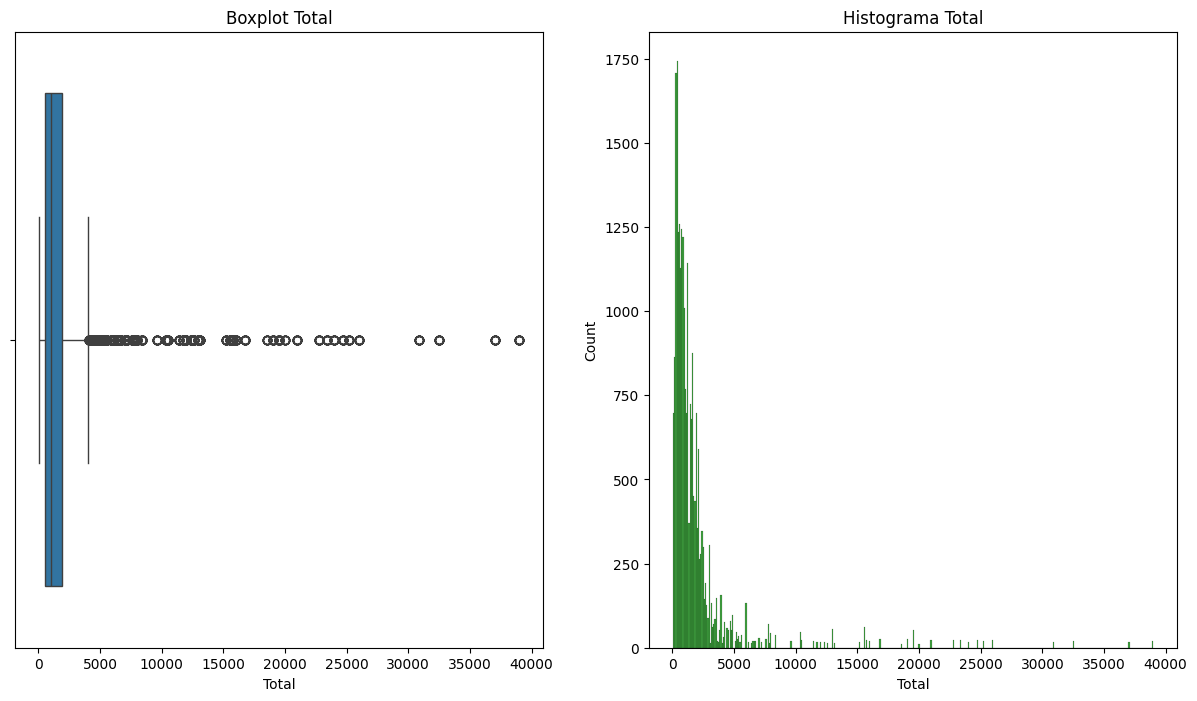

In [13]:
fig, axes = plt.subplots( ncols=2, figsize=(15, 8),)

sns.histplot(df_itens_pedidos,x="valor_total", color='green',ax=axes[1])
sns.boxplot(df_itens_pedidos,x="valor_total",ax=axes[0])

axes[0].set_title('Boxplot Total')
axes[1].set_title('Histograma Total')
axes[0].set_xlabel("Total")
axes[1].set_xlabel("Total")
plt.show()


- En nuestro box plot tenemos demasiados outliers pero esto corresponde a la diferencia de precio de productos ya que tenemos pruductos con valores demasiado altos.

- Mientras que el Histograma podemos observar que la mayor venta de productos se encuentra con un precio inferior a $5000.

In [14]:
df_productos.describe()

,producto_id,precio,sku
count,205.000000,205.000000,205.000000
mean,44803.365854,536.009756,304625.234146
std,29419.632374,843.774387,190141.444036
min,2706.000000,45.000000,101494.000000
25%,17329.000000,210.000000,222028.000000
50%,43054.000000,336.000000,263899.000000
75%,70673.000000,450.000000,304828.000000
max,100983.000000,6500.000000,952821.000000


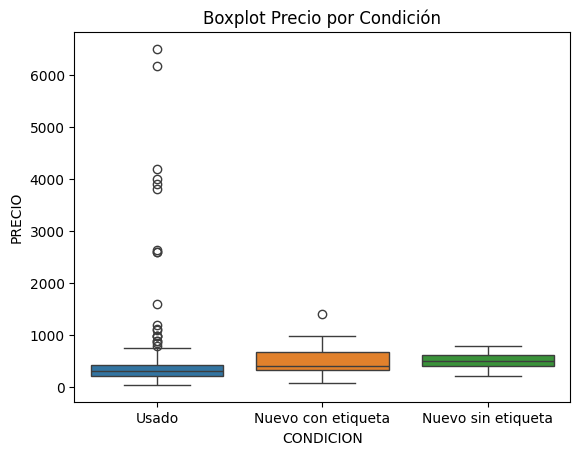

In [15]:
ax=sns.boxplot(df_productos,x="condicion",y="precio",hue="condicion")
ax.set(xlabel='CONDICION', ylabel='PRECIO')
ax.set_title("Boxplot Precio por Condición")
plt.show()

Como podemos ver la condición de usado tiene más diferenciación de precios en cuanto a las condiciones de nuevo con etiqueta y nuevo sin etiqueta.


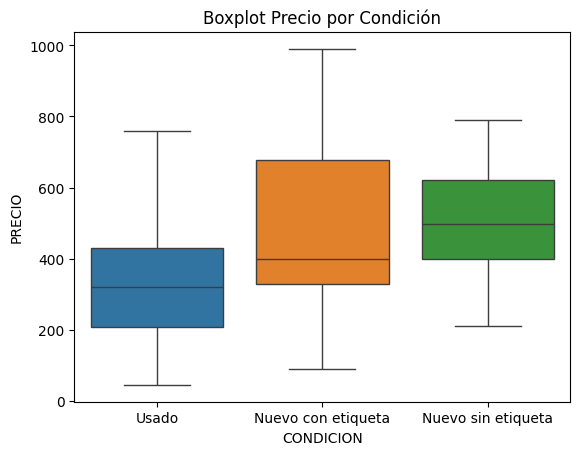

In [16]:
ax=sns.boxplot(df_productos,x="condicion",y="precio",hue="condicion",showfliers=False)
ax.set(xlabel='CONDICION', ylabel='PRECIO')
ax.set_title("Boxplot Precio por Condición")
plt.show()

Sin outliers la media de ventas es muy parecida cabe resaltar que nuevo sin etiqueta es el que tiene los precios más altos al ser vendidos.

In [17]:
df_itens_pedidos.describe()

,id_recibo,producto_id,pedido_id,cantidad,valor_unitario,valor_total,costo_envio
count,24527.000000,24527.000000,24527.000000,24527.000000,24527.00000,24527.000000,24527.000000
mean,12405.414278,44627.641171,69931.383088,3.497126,535.68867,1867.490113,373.498023
std,7242.697484,29347.824879,40560.769565,1.706170,839.21405,3379.681887,675.936377
min,1.000000,2706.000000,1.000000,1.000000,45.00000,45.000000,9.000000
25%,6132.500000,17258.000000,34487.000000,2.000000,210.00000,520.000000,104.000000
50%,12264.000000,42913.000000,69945.000000,4.000000,336.00000,1050.000000,210.000000
75%,18689.500000,70673.000000,105355.000000,5.000000,450.00000,1920.000000,384.000000
max,25055.000000,100983.000000,139993.000000,6.000000,6500.00000,39000.000000,7800.000000


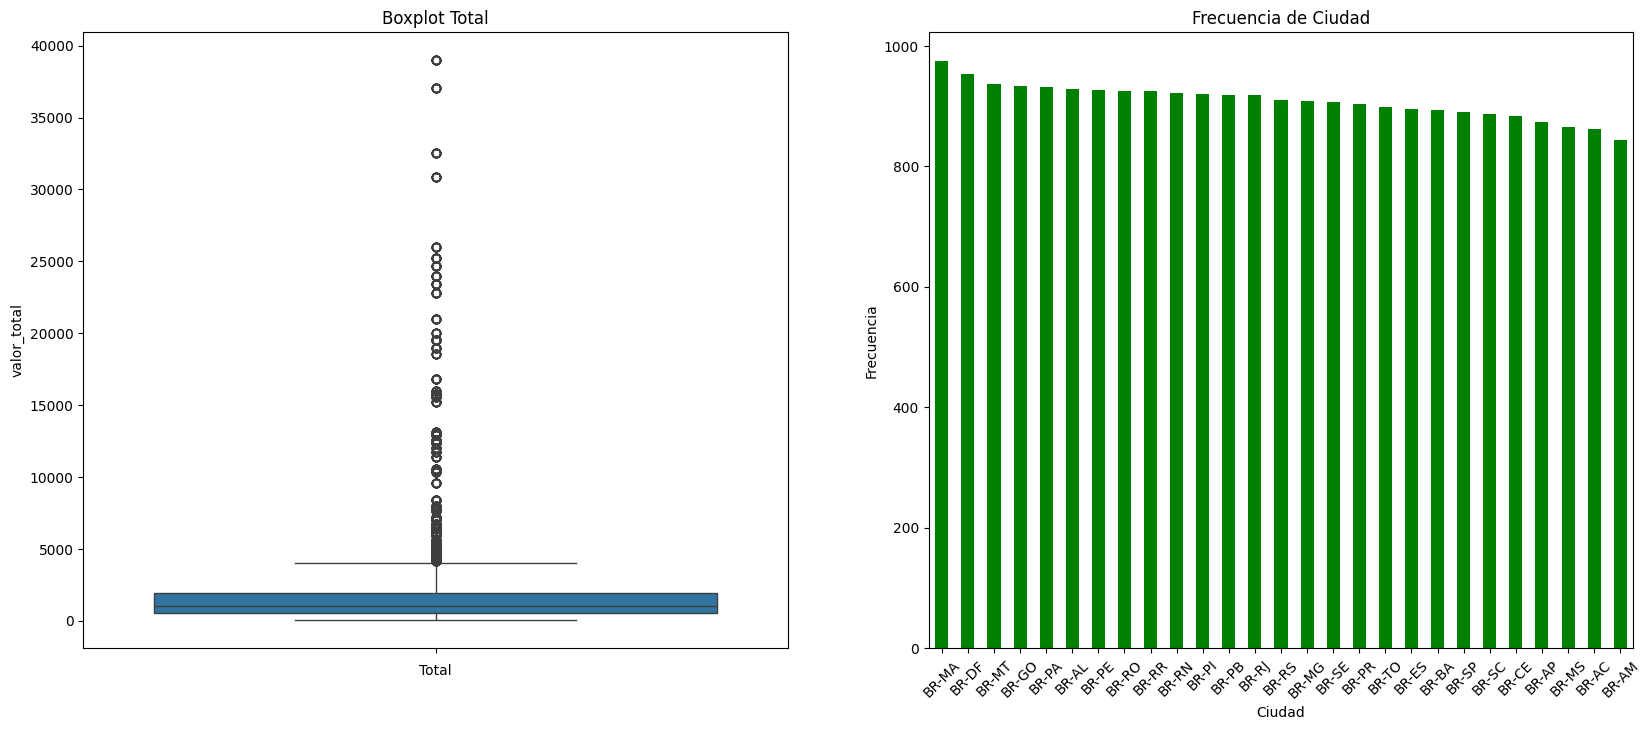

In [18]:
fig, axes = plt.subplots( ncols=2, figsize=(20, 8))

df_itens_pedidos["ciudad"].value_counts().plot(kind="bar",ax=axes[1],color="green")

sns.boxplot(df_itens_pedidos,y="valor_total",ax=axes[0])

axes[0].set_title('Boxplot Total')
axes[1].set_title('Frecuencia de Ciudad')
axes[0].set_xlabel("Total")
axes[1].set_xlabel("Ciudad")
axes[1].set_ylabel("Frecuencia")
locs, labels = plt.xticks()
plt.setp(labels, rotation=45)

plt.show()

# **3. Preguntas y respuestas**


---




## **3.1 Creando el banco de datos**

In [19]:
#@title
def crear_conexion():
  global df_itens_pedidos, df_pedidos, df_productos, df_vendedores, database
  database=create_engine('sqlite:///:memory:')
  df_itens_pedidos.to_sql('itens_pedidos',database,index=False)
  df_pedidos.to_sql('pedidos',database,index=False)
  df_productos.to_sql('productos',database,index=False)
  df_vendedores.to_sql('vendedores',database,index=False)


In [20]:
crear_conexion()
inspector = inspect(database)
print('Tablas: ', inspector.get_table_names(), '\n')
print('Columnas de Tabla Pedidos:')
for column in inspector.get_columns('pedidos'):
    print(column)
#database.dispose()

Tablas:  ['itens_pedidos', 'pedidos', 'productos', 'vendedores'] 

Columnas de Tabla Pedidos:
{'name': 'pedido_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'producto_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'vendedor_id', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'fecha_compra', 'type': DATETIME(), 'nullable': True, 'default': None, 'primary_key': 0}
{'name': 'total', 'type': BIGINT(), 'nullable': True, 'default': None, 'primary_key': 0}


## **Pregunta 1: ¿Cual es el Top 5 productos más vendidos históricamente?**

In [21]:
query='''
    SELECT ip.producto_id,p.producto,p.marca,
    SUM(valor_total) AS total_vendido, 
    SUM(cantidad) AS cantidad_vendida
    FROM itens_pedidos  ip
    INNER JOIN productos  p ON p.producto_id=ip.producto_id
    GROUP BY ip.producto_id
    ORDER BY cantidad_vendida DESC
    LIMIT 5
    '''
df=pd.read_sql(sql=text(query),con=database.connect())


C:\Users\Gabriel Chavez\AppData\Local\Temp\ipykernel_20796\579857114.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)


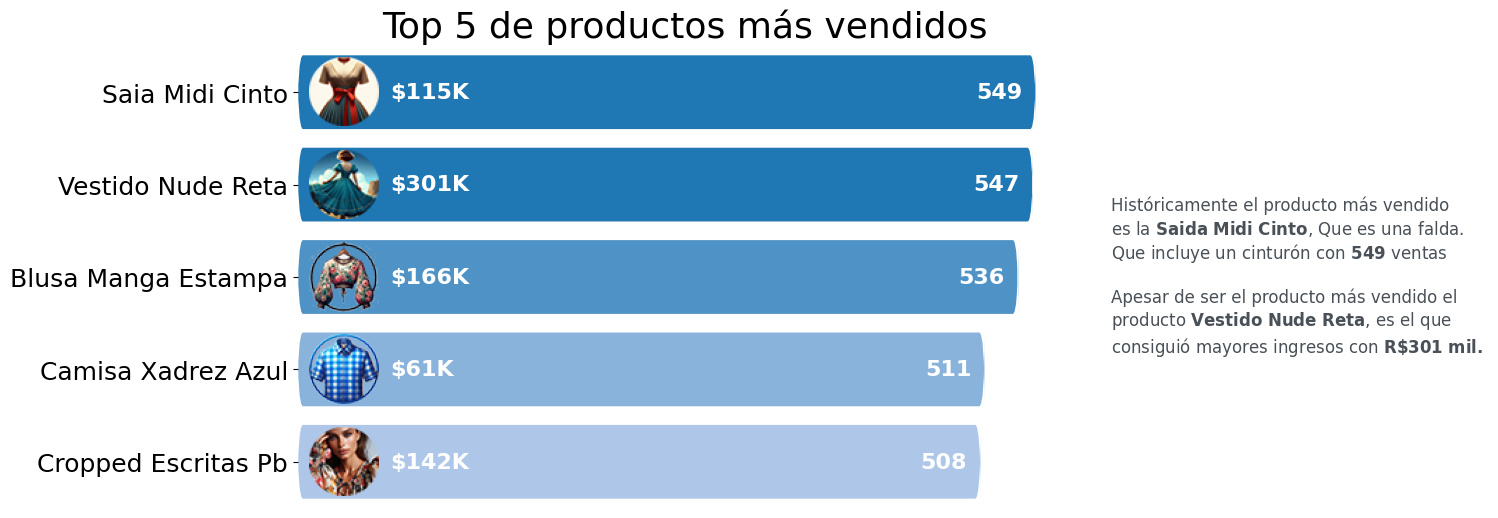

In [22]:
# Crear el gráfico de barras horizontales con Seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='cantidad_vendida', y='producto', data=df, orient='h')

# Quitar la cuadrícula del fondo
ax.grid(False)

# Quitar el cuadro delimitador
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Eliminar etiquetas y ticks del eje y
ax.set_xticks([])
ax.tick_params(axis='x', which='both', length=0)

# Eliminar el título del eje x
ax.set_xlabel('')

# Eliminar el título del eje y
ax.set_ylabel('')

# Añadir título
plt.title('Top 5 de productos más vendidos', fontsize=26)
# Aumentar el tamaño de las etiquetas del eje y
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
#ax.set_yticks(yticklabels)



# Obtener límites del eje x y eje y
x_limits = ax.get_xlim()
y_limits = ax.get_ylim()

# Obtener el producto más vendido y su información
producto_mas_vendido = df.iloc[0]  # Tomamos la primera fila ya que está ordenada por cantidad vendida
producto_segundo_mas_vendido = df.iloc[1]
segunda_venta_mayor=df.iloc[1]
nombre_producto_mas_vendido = producto_mas_vendido['producto']
segundo_nombre_producto_mas_vendido= producto_segundo_mas_vendido['producto']
cantidad_vendida_mas_vendida = producto_mas_vendido['cantidad_vendida']
ventas_producto_mas_vendido = segunda_venta_mayor['total_vendido']

conclusion_text=(
    "Históricamente el producto más vendido\n"
    "es la $\\bf{Saida\\ Midi\\ Cinto}$, Que es una falda.\n"
    "Que incluye un cinturón con $\\bf{549}$ ventas\n\n"
    "Apesar de ser el producto más vendido el \n"
   "producto $\\bf{Vestido\\ Nude\\ Reta}$, es el que\n"
    "consiguió mayores ingresos con $\\bf{R \\$301\\ mil}.$ "

)

ax.text(x_limits[1] + (x_limits[1] - x_limits[0]) * 0.05,(y_limits[0] + y_limits[1]) / 2,conclusion_text,fontsize=12,color='#495057',va='center',ha='left')
# Añadir texto adicional debajo de la línea
#ax.text(x_limits[1] + (x_limits[1] - x_limits[0]) * 0.05,
 #        (y_limits[0] + y_limits[1]) / 2,
  #       'Históricamente el producto más vendido\n'
   #      f'es la $\\bf{nombre_producto_mas_vendido}$, que es un falda\n'
    #     f'que incluye un cinturón, con {cantidad_vendida_mas_vendida} ventas \n'
     #    '\n'
      #   '\n'
       #  'A pesar de ser el producto más vendido, el \n'
        # f'producto {segundo_nombre_producto_mas_vendido}, es el que \n'
         #f'consiguió mayores ingresos con ${ventas_producto_mas_vendido/1000:.0f}K ',
         #fontsize=18,
         #ha='left',  # Alinear a la izquierda horizontalmente
         #va='center')  # Centrar verticalmente

# Crear colormap personalizado
colors = [ '#aec7e8','#1f77b4']
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)

new_patches = []
for i, patch in enumerate(reversed(ax.patches)):
    bb = patch.get_bbox()
    color = cmap(i / len(ax.patches))  # Aplicar el degradado de color
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            # Aumentar el tamaño de los bordes redondeados
                            boxstyle="round,pad=-0.0040,rounding_size=4",
                            ec="none", fc=color,
                            mutation_aspect=0.2
                            )
    patch.remove()
    new_patches.append(p_bbox)

for patch in new_patches:
    ax.add_patch(patch)

# Añadir valores de total_cantidad al final y dentro de cada barra en color blanco
for i, row in df.iterrows():
    x_pos = row['cantidad_vendida']-10
    y_pos = i
    ax.text(x_pos, y_pos, str(row['cantidad_vendida']),
            ha='right', va='center', color='white', fontsize=16, weight='bold')

# Calcular la posición x fija para todos los textos de total_vendido
x_pos = df['cantidad_vendida'].max() - 480

# Añadir valores de total_vendido al principio de cada barra en negrita y formato de miles con símbolo de dólar
for i, row in df.iterrows():
    y_pos = i
    total_vendido = row['total_vendido'] / 1000  # Convertir a miles
    ax.text(x_pos, y_pos, f"${total_vendido:.0f}K",  # Mostrar en miles con el símbolo de dólar
            ha='left', va='center', color='white', fontsize=16, fontweight='bold')

# Obtener el valor máximo de total_cantidad
max_total_cantidad = df['cantidad_vendida'].max()


# Diccionario con las rutas de las imágenes para cada producto
image_paths = {
    'Producto 1': 'https://ceibe.eu/bootcamp/saia.png',
    'Producto 2': 'https://ceibe.eu/bootcamp/vestido.png',
    'Producto 3': 'https://ceibe.eu/bootcamp/blusa.png',
    'Producto 4': 'https://ceibe.eu/bootcamp/camisa.png',
    'Producto 5': 'https://ceibe.eu/bootcamp/cropped.png'
}

# Directorio para almacenar las imágenes descargadas
image_dir = 'images'
if not os.path.exists(image_dir):
    os.makedirs(image_dir)

# Descargar y guardar las imágenes
for producto, url in image_paths.items():
    filename = os.path.join(image_dir, f"{producto}.jpg")
    urlretrieve(url, filename)

# Añadir imágenes a la derecha de cada producto
for i, (producto, filename) in enumerate(image_paths.items()):
    img = Image.open(os.path.join(image_dir, f"{producto}.jpg"))
    imagebox = OffsetImage(img, zoom=1)  # Ajustar el tamaño de la imagen según sea necesario
    x_pos = max_total_cantidad - 515  # Mover un poco a la derecha del valor máximo
    y_pos = i
    ab = AnnotationBbox(imagebox, (x_pos, y_pos), frameon=False, pad=0.2)
    ax.add_artist(ab)
# Mostrar el gráfico
plt.show()

## Pregunta 1.1: **Según la condición de la ropa, ¿Cuál es el que más ventas tuvo históricamente? (insight extra)**

In [23]:
crear_conexion()
query='''
    SELECT ip.producto_id,
    SUM(valor_total) AS total_vendido,
    SUM(cantidad) AS cantidad_vendida,
    condicion as condicion_ropa
    FROM itens_pedidos ip
    INNER JOIN productos p ON p.producto_id=ip.producto_id
    GROUP BY p.condicion
    '''
df_condicion=pd.read_sql(sql=text(query),con=database.connect())



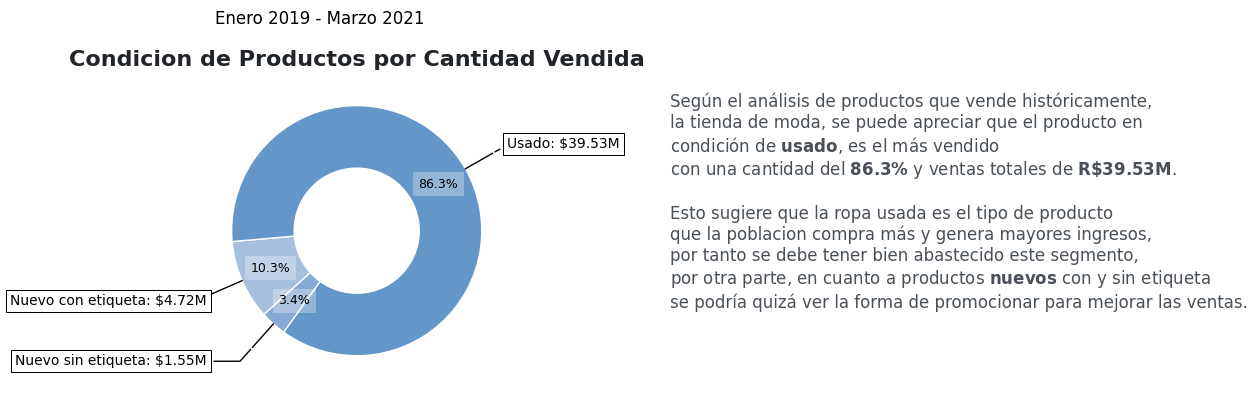

In [24]:
df_condicion['total_vendidos'] = (df_condicion['total_vendido'] / 1000000).apply(lambda x: f'${x:.2f}M')

# Configuración básica de los gráficos
fig, axs = plt.subplots(figsize=(7, 4))
colores = ['#a5bfde', '#86aad3', '#6496c8']


myexplode = [0.2, 0, 0, 0]
# Gráfico de donapie_ax.pie(porcentajes, labels=df_plot['marca'], autopct='%1.0f%%', startangle=140, colors=colors)
wedges_con, texts_con, autotexts_con = axs.pie(df_condicion['total_vendido'], colors=colores, autopct='%1.1f%%',
                                                       textprops={'fontsize': 9, 'bbox': dict(facecolor="white", edgecolor="black", linewidth=0, alpha=0.3)}, pctdistance=0.75,
                                                       startangle=185, wedgeprops=dict(width=0.5, edgecolor='w'))
                                                      

bbox_condicion = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
lines = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_condicion, zorder=0, va="center")


for i, p in enumerate(wedges_con):
    ang = (p.theta2 - p.theta1) / 2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]

    # Coordenadas para trazar la línea de conexión
    x_line = 1.25 * np.cos(np.deg2rad(ang))
    y_line = 1.25 * np.sin(np.deg2rad(ang))
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    lines["arrowprops"].update({"connectionstyle": connectionstyle})

    # Anotar el texto
    axs.plot([x, x_line], [y, y_line], color='black', linestyle='-', linewidth=1)
    axs.annotate(df_condicion['condicion_ropa'][i] + ': ' + str(df_condicion['total_vendidos'][i]), xy=(x_line, y_line),
                    xytext=(1.2 * np.sign(x), 1.4 * y),
                    horizontalalignment=horizontalalignment, **lines, fontsize=10)
    
    
  

plt.title('Condicion de Productos por Cantidad Vendida', fontsize = 16, fontweight='bold', color='#212529')
plt.suptitle('Enero 2019 - Marzo 2021')
#axs.set_title('Enero 2019 - Marzo 2021', fontsize = 12, fontweight='bold', color='#212529')
# Agregar conclusion a la derecha del gráfico
conclusion_text = ("Según el análisis de productos que vende históricamente,\n"
  "la tienda de moda, se puede apreciar que el producto en\n"
  "condición de $\\bf{usado}$, es el más vendido\n"
  "con una cantidad del $\\bf{86.3 \%}$ y ventas totales de $\\bf{R \$ 39.53M}$.\n\n"
  "Esto sugiere que la ropa usada es el tipo de producto\n"
  "que la poblacion compra más y genera mayores ingresos, \n"
  "por tanto se debe tener bien abastecido este segmento, \n"
  "por otra parte, en cuanto a productos $\\bf{nuevos}$ con y sin etiqueta\n"
  "se podría quizá ver la forma de promocionar para mejorar las ventas.")
fig.text(1, 0.5, conclusion_text, fontsize=12, color='#495057', va='center', ha='left')

plt.tight_layout()
plt.show()

## **Pregunta 2: ¿Cual es la evolución histórica de las ingresos netos?**

In [25]:
query='''
    SELECT strftime('%Y-%m-%d',ped.fecha_compra) AS fecha_compra,
    SUM(total-costo_envio) AS total_ventas 
    FROM itens_pedidos  ip
    INNER JOIN pedidos ped ON ped.pedido_id=ip.pedido_id
    GROUP BY ped.fecha_compra
    ORDER BY fecha_compra ASC

    '''
df2=pd.read_sql(sql=text(query),con=database.connect())



In [26]:
#Convertimos las fechas a datetime

df2['fecha_compra'] = pd.to_datetime(df2['fecha_compra'])

# Definir la consulta SQL para obtener las marcas más vendidas en el día específico
query_marcas = """
    SELECT marca, SUM(cantidad * precio) AS ventas_totales
    FROM itens_pedidos ip
    INNER JOIN productos p ON ip.producto_id = p.producto_id
    INNER JOIN pedidos ped ON ip.pedido_id = ped.pedido_id
    WHERE strftime('%Y-%m-%d', ped.fecha_compra) = '2019-11-24'
    GROUP BY marca
    ORDER BY ventas_totales DESC;
"""
# Ejecutar la consulta SQL y guardar el resultado en un DataFrame
df_marcas = pd.read_sql_query(query_marcas, database)

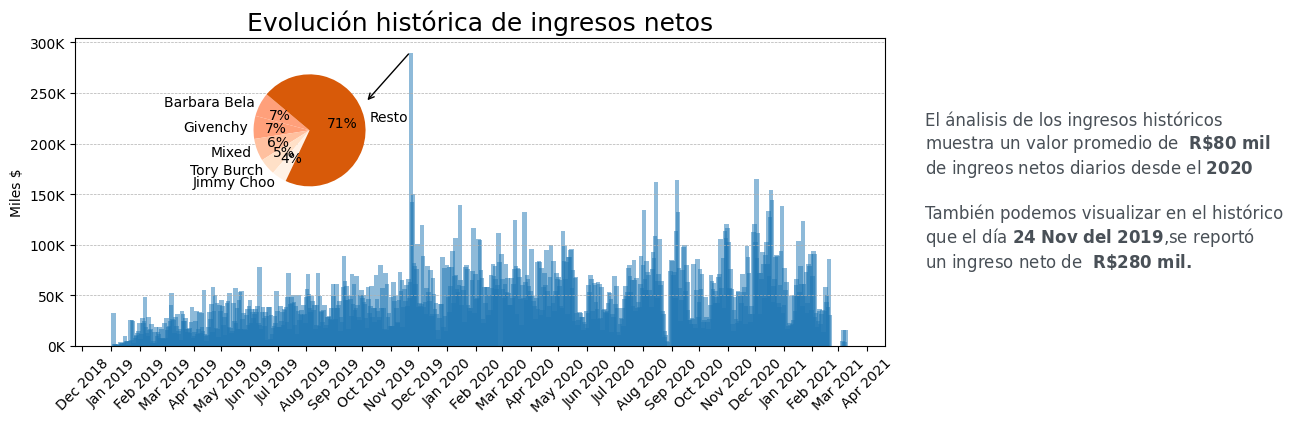

In [27]:

# Tomar las primeras 5 marcas y sumar el resto de las ventas
top_5_marcas = df_marcas.head(5)
resto_ventas = df_marcas.iloc[5:]['ventas_totales'].sum()

# Crear un nuevo DataFrame con las primeras 5 marcas y el resto de las ventas
df_plot = pd.concat([top_5_marcas, pd.DataFrame({'marca': ['Resto'], 'ventas_totales': [resto_ventas]})])

# Calcular los porcentajes de las ventas para cada marca
porcentajes = (df_plot['ventas_totales'] / df_plot['ventas_totales'].sum() * 100)
#porcentajes=np.ceil(porcentajes)

# Crear un degradado de marrón comenzando con el color #D85A09 y yendo hacia tonos más claros
colors = ['#FFA07b', '#FFA07A', '#FFC09F', '#FFE0C7', '#FFF2E6', '#D85A09']

# Crear la figura y los objetos de ejes
fig, ax = plt.subplots(figsize=(12, 4))

# Dibujar el gráfico de barras

ax.bar(df2.fecha_compra, df2.total_ventas, width = 5, alpha=0.5)
ax.xaxis.set_major_locator(mdates.DayLocator(2)) # show every 2 years on the x-axis 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
# Formatear el eje X
plt.xticks(rotation=45)

# Formatear los números en el eje y como "100k"
formatter = FuncFormatter(lambda x, _: f'{x / 1000:.0f}K')
ax.yaxis.set_major_formatter(formatter)

ax.set_ylabel('Miles $')

# Agregar título al gráfico
plt.title('Evolución histórica de ingresos netos', fontsize=18)

# Rotar el eje x a 45 grados
plt.xticks(rotation=45)

# Agregar espacio a la derecha del gráfico para el texto "lorem ipsum"
fig.subplots_adjust(right=0.8)  # Ajusta el valor según el espacio deseado
# Obtener límites del eje x y eje y
x_limits = ax.get_xlim()
y_limits = ax.get_ylim()


# Agregar el texto "lorem ipsum" centrado horizontal y verticalmente en el espacio a la derecha

conclusion_text=(
    "El ánalisis de los ingresos históricos\n"
    "muestra un valor promedio de  $\\bf{R \\$80\\ mil}$ \n"
    "de ingreos netos diarios desde el $\\bf{2020}$ \n\n"
    "También podemos visualizar en el histórico \n"
   "que el día $\\bf{24\\ Nov\\ del\\ 2019}$,se reportó\n"
    "un ingreso neto de  $\\bf{R \\$280\\ mil}.$ "

)

ax.text(x_limits[1] + (x_limits[1] - x_limits[0]) * 0.05,(y_limits[0] + y_limits[1]) / 2,conclusion_text,fontsize=12,color='#495057',va='center',ha='left')

# Mostrar líneas horizontales en el grid
ax.grid(axis='y', linestyle='--', linewidth=0.5)


# Dibujar el gráfico de pastel superpuesto
pie_ax = ax.inset_axes([0.09, 0.5, 0.4, 0.4])  # Posición y tamaño del gráfico de pastel

pie_ax.pie(porcentajes, labels=df_plot['marca'], autopct='%1.0f%%', startangle=140, colors=colors)
pie_ax.axis('equal')



# Añadir la flecha desde el gráfico de pastel
pie_ax.annotate('', xy=(1, 0.5), xytext=(1.8, 1.4), arrowprops=dict(facecolor='blue', arrowstyle='->'))


# Mostrar el gráfico
plt.show()


## **Pregunta 2.1:¿Cuál es la causa del repunte del día 24 de Nov del 2019? (insight extra)**

In [28]:
query = '''
    SELECT strftime('%Y-%m-%d',ped.fecha_compra) AS fecha_compra,
           SUM(total-costo_envio) AS total_ventas
    FROM itens_pedidos ip
    INNER JOIN pedidos ped ON ped.pedido_id=ip.pedido_id
    GROUP BY ped.fecha_compra
    ORDER BY fecha_compra ASC
'''
df=pd.read_sql(sql=text(query),con=database.connect())


In [29]:

query_df_total_cantidad = '''
    SELECT strftime('%Y-%m-%d', ped.fecha_compra) AS fecha_compra,
           SUM(total - costo_envio) AS total_ventas,
           SUM(ip.cantidad) AS total_cantidad
    FROM itens_pedidos ip
    INNER JOIN pedidos ped ON ped.pedido_id = ip.pedido_id
    GROUP BY ped.fecha_compra
    ORDER BY fecha_compra ASC
'''

# Ejecutar la consulta y guardar el resultado en un dataframe
df_total_cantidad=pd.read_sql(sql=text(query_df_total_cantidad),con=database.connect())



In [30]:

query_df_total_cantidad_dia_x = '''
    SELECT strftime('%Y-%m-%d', ped.fecha_compra) AS fecha_compra,
           SUM(total - costo_envio) AS total_ventas,
           SUM(ip.cantidad) AS total_cantidad
    FROM itens_pedidos ip
    INNER JOIN pedidos ped ON ped.pedido_id = ip.pedido_id
    WHERE strftime('%Y-%m-%d', ped.fecha_compra) = '2019-11-24'
    GROUP BY ped.fecha_compra
    ORDER BY fecha_compra ASC
'''
# Ejecutar la consulta y guardar el resultado en un dataframe
df_total_cantidad_dia_x = pd.read_sql(sql=text(query_df_total_cantidad_dia_x),con=database.connect())

La media de ventas por vendedor es: 57992.159999999996


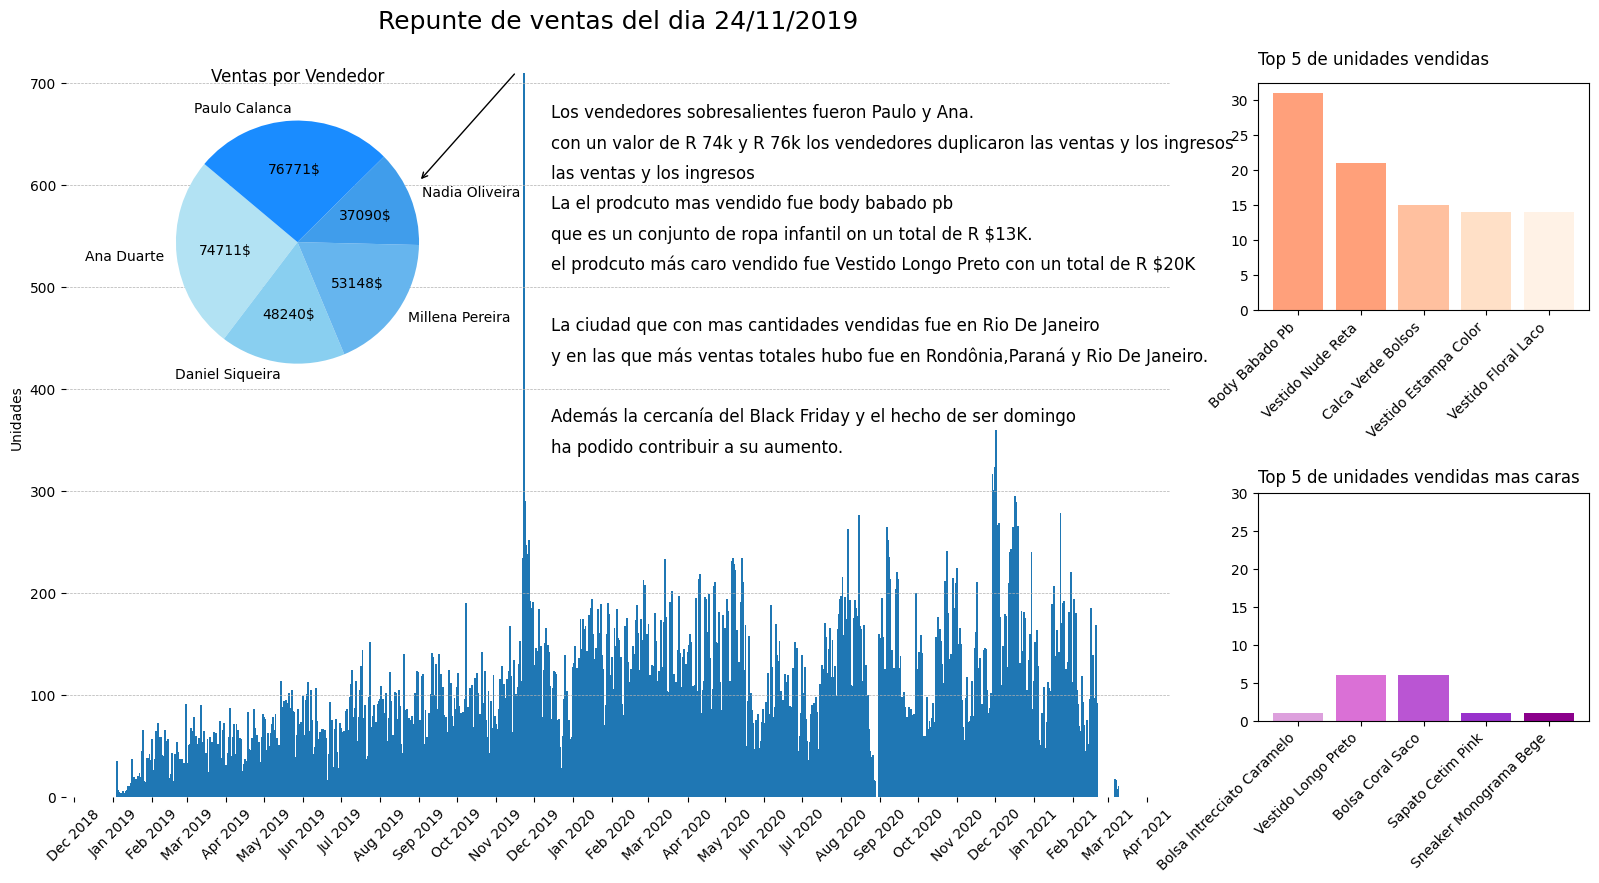

In [31]:
#Convertimos las fechas a datetime
df_total_cantidad['fecha_compra'] = pd.to_datetime(df['fecha_compra'])

# Definir la consulta SQL para obtener las marcas más vendidas en el día específico
query_productos_5 = """
SELECT t.producto_id,
       t.producto,
       t.precio,
       SUM(t.cantidad) AS cantidad_total,
       SUM(t.cantidad * t.precio) AS total_por_precio
FROM (
    SELECT p.producto_id,
           p.producto,
           p.precio,
           ip.cantidad
    FROM itens_pedidos ip
    INNER JOIN productos p ON ip.producto_id = p.producto_id
    INNER JOIN pedidos ped ON ip.pedido_id = ped.pedido_id
    WHERE strftime('%Y-%m-%d', ped.fecha_compra) = '2019-11-24'
    AND p.precio = (
        SELECT MAX(precio)
        FROM productos
        WHERE producto = p.producto
    )
) AS t
GROUP BY t.producto_id, t.producto, t.precio
ORDER BY cantidad_total DESC
LIMIT 5;
"""

query_productos_5_caros = """
SELECT t.producto_id,
       t.producto,
       t.precio,
       SUM(t.cantidad) AS cantidad_total,
       SUM(t.cantidad * t.precio) AS total_por_precio
FROM (
    SELECT p.producto_id,
           p.producto,
           p.precio,
           ip.cantidad
    FROM itens_pedidos ip
    INNER JOIN productos p ON ip.producto_id = p.producto_id
    INNER JOIN pedidos ped ON ip.pedido_id = ped.pedido_id
    WHERE strftime('%Y-%m-%d', ped.fecha_compra) = '2019-11-24'
    AND p.precio = (
        SELECT MAX(precio)
        FROM productos
        WHERE producto = p.producto
    )
) AS t
GROUP BY t.producto_id, t.producto, t.precio
ORDER BY precio DESC
LIMIT 5;
"""

query_vendedores="""
SELECT
    ven.nombre_vendedor,
    SUM(CASE WHEN DATE(ped.fecha_compra) = '2019-11-24' THEN ip.valor_total - ip.costo_envio ELSE 0 END) AS Total_neto
FROM
    itens_pedidos ip
    INNER JOIN pedidos ped ON ped.pedido_id = ip.pedido_id
    INNER JOIN vendedores ven ON ven.vendedor_id = ped.vendedor_id
GROUP BY
    ven.nombre_vendedor
LIMIT 5;
"""



# Ejecutar la consulta SQL y guardar el resultado en un DataFrame
df_productos_5 = pd.read_sql(sql=text(query_productos_5),con=database.connect())
# Tomar los primeros 5 productos y sumar el resto de las ventas
top_5_productos = df_productos_5.head(5)
# Crear un degradado de marrón comenzando con el color #D85A09 y yendo hacia tonos más claros
colors = ['#FFA07b', '#FFA07A', '#FFC09F', '#FFE0C7', '#FFF2E6', '#D85A09']

# Ejecutar la consulta SQL y guardar el resultado en un DataFrame
df_productos_5_caros = pd.read_sql(sql=text(query_productos_5_caros),con=database.connect())
# Tomar los primeros 5 productos y sumar el resto de las ventas
top_5_productos_caros = df_productos_5_caros.head(5)
colores_caros = ['#DDA0DD', '#DA70D6', '#BA55D3', '#9932CC', '#8B008B', '#9400D3']

# Ejecutar la consulta SQL y guardar el resultado en un DataFrame
df_vendedores = pd.read_sql(sql=text(query_vendedores),con=database.connect())
# Tomar los primeros 5 productos y sumar el resto de las ventas
df_vendedores = df_vendedores.head(5)
colores_vendedores = ['#B2E2F3', '#89CFF0', '#66B5EE', '#409DEB', '#1A8CFF', '#B0DFE5']

# Hallar la media de unidades vendidas
media_unidades = round(df_total_cantidad.total_cantidad.mean(), 2)
# Hallar la suma de unidades vendidas
suma_unidades = round(df_total_cantidad_dia_x.total_cantidad.sum(), 2)

# Calcular la media de ventas por vendedor
media_ventas_por_vendedor = df_vendedores['Total_neto'].mean()
# Imprimir la media de ventas por vendedor
print(f"La media de ventas por vendedor es: {media_ventas_por_vendedor}")


# Crear la figura y los objetos de ejes
fig, ax = plt.subplots(figsize=(16, 9))
# Dibujar el gráfico de barras
ax.bar(df_total_cantidad.fecha_compra, df_total_cantidad.total_cantidad, width=1.5)
ax.xaxis.set_major_locator(mdates.DayLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
# Formatear el eje X
plt.xticks(rotation=45)
#quitar cuadro delimitador
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


ax.set_ylabel('Unidades')
# Agregar título al gráfico
plt.title('Repunte de ventas del dia 24/11/2019', fontsize=18)
# Rotar el eje x a 45 grados
plt.xticks(rotation=45)

# Agregar espacio a la derecha del gráfico para el texto
fig.subplots_adjust(right=0.8)  # Ajusta el valor según el espacio deseado
ax_text = ax.twinx()
ax_text.axis('off')
ax_text.text(1.08, 0.97, 'Top 5 de unidades vendidas', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')
ax_text.text(1.08, 0.42, f'Top 5 de unidades vendidas mas caras', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')
ax_text.text(0.44, 0.90, f'Los vendedores sobresalientes fueron Paulo y Ana. ', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')
#$\\bf{R \\$4M}$
ax_text.text(0.44, 0.86, f'con un valor de R 74k y R 76k los vendedores duplicaron las ventas y los ingresos', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')
ax_text.text(0.44, 0.82, f'las ventas y los ingresos', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')
#ax_text.text(0.44, 0.90, f'El valor promedio de unidades vendidas históricamente es de {media_unidades}u. ', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')
#ax_text.text(0.44, 0.86, f'muy por debajo del repunte observado del día 24/11/2019', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')
ax_text.text(0.44, 0.82, f'', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')

ax_text.text(0.44, 0.78, f'La el prodcuto mas vendido fue body babado pb ', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')
ax_text.text(0.44, 0.74, f'que es un conjunto de ropa infantil on un total de R $13K.', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')
ax_text.text(0.44, 0.70, f'el prodcuto más caro vendido fue Vestido Longo Preto con un total de R $20K', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')

#ax_text.text(0.44, 0.78, f'La suma de unidades de ese día esta en {suma_unidades}u. Se observa en ', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')
#ax_text.text(0.44, 0.74, f'los gráficos de barras como los productos mas caros', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')
#ax_text.text(0.44, 0.70, f'apenas han tenido incidencia en el mismo.', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')
ax_text.text(0.44, 0.66, f'', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')

ax_text.text(0.44, 0.62, f'La ciudad que con mas cantidades vendidas fue en Rio De Janeiro', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')
ax_text.text(0.44, 0.58, f'y en las que más ventas totales hubo fue en Rondônia,Paraná y Rio De Janeiro.', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')

#ax_text.text(0.44, 0.62, f'Podemos afirmar que el repunte de ventas tiene a los vendedores', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')
#ax_text.text(0.44, 0.58, f'como responsables ya que su media es de 1494$.', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')
ax_text.text(0.44, 0.54, f'', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')
ax_text.text(0.44, 0.50, f'Además la cercanía del Black Friday y el hecho de ser domingo', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')
ax_text.text(0.44, 0.46, f'ha podido contribuir a su aumento.', transform=ax_text.transAxes, va='center', ha='left', fontsize='12')

## Mostrar líneas horizontales en el grid
ax.grid(axis='y', linestyle='--', linewidth=0.5)


# Crear un nuevo eje para el gráfico de barras
bar_ax = ax.inset_axes([1.08, 0.64, 0.3, 0.3])  # Posición y tamaño del gráfico de barras
# Dibujar el gráfico de barras verticales
bar_ax.bar(range(len(top_5_productos['producto'])), top_5_productos['cantidad_total'], color=colors)
# Asignar los nombres de los productos como etiquetas del eje x
bar_ax.set_xticks(range(len(top_5_productos['producto'])))
bar_ax.set_xticklabels(top_5_productos['producto'], rotation=45, ha='right')

# Crear un nuevo eje para el gráfico de barras
bar_ax = ax.inset_axes([1.08, 0.10, 0.3, 0.3])  # Posición y tamaño del gráfico de barras
# Dibujar el gráfico de barras verticales
bar_ax.bar(range(len(df_productos_5_caros['producto'])), df_productos_5_caros['cantidad_total'], color=colores_caros)
# Asignar los nombres de los productos como etiquetas del eje x
bar_ax.set_xticks(range(len(df_productos_5_caros['producto'])))
bar_ax.set_xticklabels(df_productos_5_caros['producto'], rotation=45, ha='right')
#bar_ax.set_ylabel('Top productos mas caros')

# Ajustar el límite del eje y para que llegue hasta 30
bar_ax.set_ylim(0, 30)

# Crear un gráfico de pastel con los totales de ventas por vendedor
pie_ax = ax.inset_axes([0.01, 0.53, 0.4, 0.4])  # Posición y tamaño del gráfico de pastel
pie_ax.pie(df_vendedores['Total_neto'], labels=df_vendedores['nombre_vendedor'], autopct=lambda p: f'{p * sum(df_vendedores["Total_neto"]) / 100:.0f}$', startangle=140, colors=colores_vendedores)
pie_ax.set_title('Ventas por Vendedor')

# Añadir la flecha desde el gráfico de pastel
pie_ax.annotate('', xy=(1, 0.5), xytext=(1.8, 1.4), arrowprops=dict(facecolor='black', arrowstyle='->'))
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### Analisis sobre el día 24 Noviembre 2019

In [32]:
df_limpio=pd.read_csv("https://ceibe.eu/bootcamp/lista.csv")
df_limpio=df_limpio.drop("Unnamed: 0",axis=1)
df_limpio=df_limpio.drop_duplicates().reset_index(drop=True)
df_limpio["total_neto"]=(df_limpio["total"])-(df_limpio["costo_envio"])


In [33]:
#Todo sobre el vendedor desconocido
df_limpio[df_limpio["nombre_vendedor"]=="Unknown"]

,producto_id,pedido_id,cantidad,valor_unitario,valor_total,costo_envio,abbrev_state,name_state,name_region,vendedor_id,fecha_compra,total,producto,precio,marca,sku,condicion,nombre_vendedor,total_neto
24526,41518,341,3,260,780,156.0,BA,Bahia,Nordeste,6,2019-01-05,780,Calca Jeans Basica,260,Banana Republic,255410.0,Nuevo con etiqueta,Unknown,624.0


#### Media de ventas en comparacion de los otros años

In [34]:
# Media de ventas solamente del dia 2019 
media_del_dia_bueno=df_limpio[df_limpio["fecha_compra"]=="2019-11-24"]
media=media_del_dia_bueno.groupby("nombre_vendedor")["total_neto"].sum().reset_index()
media

,nombre_vendedor,total_neto
0,Ana Duarte,74711.2
1,Daniel Siqueira,48240.0
2,Millena Pereira,53148.0
3,Nadia Oliveira,37090.4
4,Paulo Calanca,76771.2


In [35]:
total=media_del_dia_bueno["total_neto"].mean()
total

1367.7396226415094

In [36]:
# Media de ventas todos los dias menos del dia bueno
media_del_dia_bueno=df_limpio[df_limpio["fecha_compra"]!="2019-11-24"]
media_todos_los_demasfechas=media_del_dia_bueno.groupby("nombre_vendedor")["total_neto"].mean().reset_index()
media_todos_los_demasfechas

,nombre_vendedor,total_neto
0,Ana Duarte,1496.401792
1,Daniel Siqueira,1531.779680
2,Millena Pereira,1488.679463
3,Nadia Oliveira,1480.819476
4,Paulo Calanca,1477.049357
5,Unknown,624.000000


#### Suma de cantidad por año 2019 vs 2020

Repunte de unidades

In [37]:
cantidad_2019=df_limpio[df_limpio["fecha_compra"]=="2019-11-24"]
cantidad_2019=media_del_dia_bueno.groupby("nombre_vendedor")["cantidad"].sum().reset_index()
cantidad_2019

,nombre_vendedor,cantidad
0,Ana Duarte,17858
1,Daniel Siqueira,17594
2,Millena Pereira,14596
3,Nadia Oliveira,16871
4,Paulo Calanca,18142
5,Unknown,3


In [38]:
promedio_cantidad_2019=cantidad_2019["cantidad"].mean()
promedio_cantidad_2019

14177.333333333334

In [39]:
cantidad_2020=df_limpio[df_limpio["fecha_compra"]=="2020-11-24"]
cantidad_2020=cantidad_2020.groupby("nombre_vendedor")["cantidad"].sum().reset_index()
cantidad_2020

,nombre_vendedor,cantidad
0,Ana Duarte,48
1,Daniel Siqueira,13
2,Millena Pereira,36
3,Nadia Oliveira,22
4,Paulo Calanca,27


In [40]:
#cantidad de todas las fechas MENOS la del 24 de noviembre del 2019 
cantidad_todas_fechas=df_limpio[df_limpio["fecha_compra"]!="2019-11-24"]
cantidad_fechas=cantidad_todas_fechas.groupby("nombre_vendedor")["cantidad"].sum().reset_index()
cantidad_fechas

,nombre_vendedor,cantidad
0,Ana Duarte,17858
1,Daniel Siqueira,17594
2,Millena Pereira,14596
3,Nadia Oliveira,16871
4,Paulo Calanca,18142
5,Unknown,3


In [41]:
cantidad_todas_fechas=df_limpio[df_limpio["fecha_compra"]=="2019-11-24"]
region=cantidad_todas_fechas.groupby("name_state")["cantidad"].sum().reset_index()
region.sort_values(by="cantidad",ascending=False).head()

,name_state,cantidad
18,Rio De Janeiro,48
15,Pará,39
8,Goiás,38
4,Bahia,37
17,Piauí,34


In [42]:
cantidad_todas_fechas=df_limpio[df_limpio["fecha_compra"]=="2019-11-24"]
tota_region=cantidad_todas_fechas.groupby("name_state")["total_neto"].sum().reset_index()
tota_region.sort_values(by="total_neto",ascending=False).head()

,name_state,total_neto
21,Rondônia,24696.0
13,Paraná,22808.0
18,Rio De Janeiro,21570.4
15,Pará,18996.0
8,Goiás,18924.0


In [43]:
cantidad_todas_fechas=df_limpio[df_limpio["fecha_compra"]=="2019-11-24"]
prodcuto=cantidad_todas_fechas.groupby(["producto","cantidad"])["total_neto"].sum().reset_index()
prodcuto.sort_values(by="total_neto",ascending=False).head()

,producto,cantidad,total_neto
172,Vestido Longo Preto,6,20160.0
35,Bolsa Coral Saco,6,19200.0
132,Scarpin Bege Textura,6,12432.0
96,Oculos Lente Azulada,5,8960.0
145,Vestido Amarelo Laco,6,6720.0


In [44]:
cantidad_todas_fechas=df_limpio[df_limpio["fecha_compra"]=="2019-11-24"]
prodcuto=cantidad_todas_fechas.groupby(["producto","total_neto"])["cantidad"].sum().reset_index()
prodcuto.sort_values(by="cantidad",ascending=False).head()

,producto,total_neto,cantidad
31,Body Babado Pb,1344.0,18
179,Vestido Nude Reta,2640.0,12
106,Regata Nadador Lilas,720.0,12
96,Oculos Lente Azulada,4480.0,10
15,Blusa Fio Correntes,400.0,10


## **Pregunta 3: ¿Cuáles son los ingresos netos por vendedor por año?**

In [45]:
query='''
    SELECT ven.nombre_vendedor,
    
     
    SUM(CASE WHEN ped.fecha_compra >= "2019-01-01" AND ped.fecha_compra < "2020-01-01"THEN ip.valor_total - ip.costo_envio ELSE 0 END) AS "2019",
    SUM(CASE WHEN ped.fecha_compra >= "2020-01-01" AND ped.fecha_compra < "2021-01-01"THEN ip.valor_total - ip.costo_envio ELSE 0 END) AS "2020",
    SUM(CASE WHEN ped.fecha_compra >= "2021-01-01" AND ped.fecha_compra < "2022-01-01"THEN ip.valor_total - ip.costo_envio ELSE 0 END) AS "2021"
 
     FROM itens_pedidos  ip
   
    INNER JOIN pedidos ped ON ped.pedido_id=ip.pedido_id
    INNER JOIN vendedores ven ON ven.vendedor_id=ped.vendedor_id 

    GROUP BY ven.nombre_vendedor
    LIMIT 5
    '''

df3=pd.read_sql(sql=text(query),con=database.connect(),index_col="nombre_vendedor")

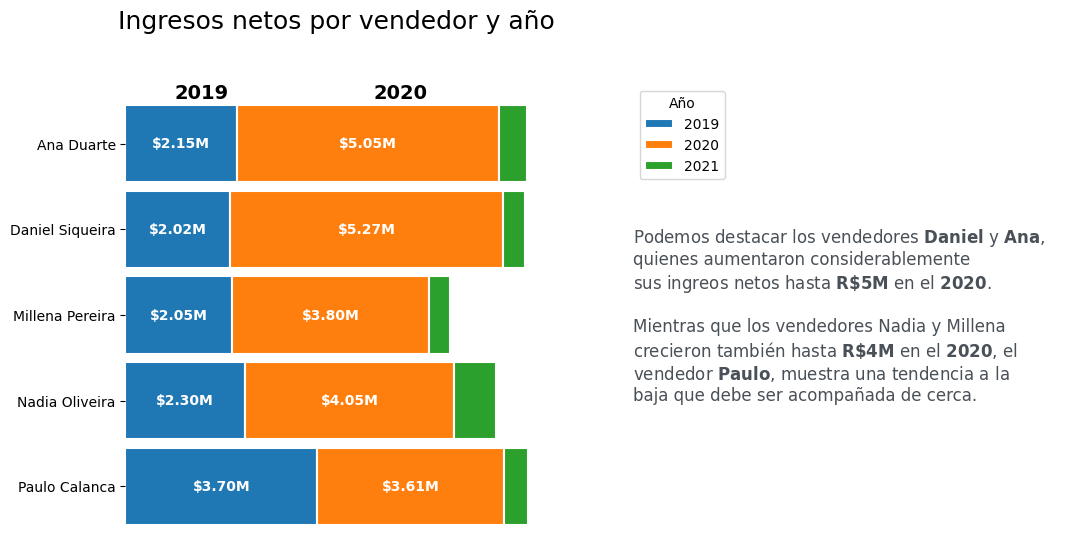

In [46]:

def plot_stacked_barh(data, category_names):
    labels = data.index
    data = data.values

    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 1]}, figsize=(12, 6))
    ax1.invert_yaxis()
    ax1.xaxis.set_visible(False)
    # Eliminar el cuadro delimitador alrededor del gráfico
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)

   # Quitar títulos y etiquetas del eje x
    ax1.set_title('')
    ax1.set_xlabel('')
    ax1.set_xticks([])

    ax1.set_title('Ingresos netos por vendedor y año', fontsize=18, pad=40)
    ax1.set_xlabel('Total ventas')
    ax1.set_ylabel('')
    ax1.legend('Año')
    ax1.get_legend().remove()  # Remover leyenda


    for i, colname in enumerate(category_names):
        widths = data[:, i]
        starts = np.cumsum(data[:, :i], axis=1)[:, -1] if i > 0 else 0
        bars = ax1.barh(labels, widths, left=starts, height=0.9, edgecolor='white', linewidth=1.5,
                 label=colname)


        for bar, c in zip(bars, data[:, i]):
            if colname != "2021":  # Omitir el texto para el año 2021
                ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + bar.get_height() / 2,
                         f'${c / 1000000:.2f}M', ha='center', va='center', color='white', fontweight='bold')

    ax1.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')


    conclusion_text=(
    "Podemos destacar los vendedores $\\bf{Daniel}$ y $\\bf{Ana}$,\n"
    "quienes aumentaron considerablemente\n"
    "sus ingreos netos hasta $\\bf{R \\$5M}$ en el $\\bf{2020}$.\n\n"
    
    "Mientras que los vendedores Nadia y Millena\n"
    "crecieron también hasta $\\bf{R \\$4M}$ en el $\\bf{2020}$, el\n"
    "vendedor $\\bf{Paulo}$, muestra una tendencia a la\n"
    "baja que debe ser acompañada de cerca."

    )

    ax2.text( 0,0.5,conclusion_text,fontsize=12,color='#495057',va='center',ha='left')
    ax2.axis('off')

    # Espacio para comentarios
  
   


    # Crear leyenda para el segundo subplot
    handles, labels = ax1.get_legend_handles_labels()
    ax2.legend(handles, labels, loc='upper left', title='Año')
    ax1.get_legend().remove()  # Remover leyenda

    # Agregar texto "2019" y "2020" en negrita encima del gráfico
    ax1.text(0.18, 0.98, '2019', ha='center', va='center', fontsize=14, fontweight='bold', transform=ax1.transAxes)
    ax1.text(0.65, 0.98, '2020', ha='center', va='center', fontsize=14, fontweight='bold', transform=ax1.transAxes)


    return fig, (ax1, ax2)

plot_stacked_barh(df3, ["2019", "2020", "2021"])
plt.show()

## **Pregunta 4: ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?**

In [47]:
query='''
    SELECT ip.ciudad,
    SUM(total-costo_envio) AS ingresos_netos,
    SUBSTRING(ciudad,4,4) AS abbrev_state 
    
 
    FROM itens_pedidos  ip
   
    INNER JOIN pedidos ped ON ped.pedido_id=ip.pedido_id
   

    GROUP BY ciudad
    '''

df4=pd.read_sql(sql=text(query),con=database.connect())

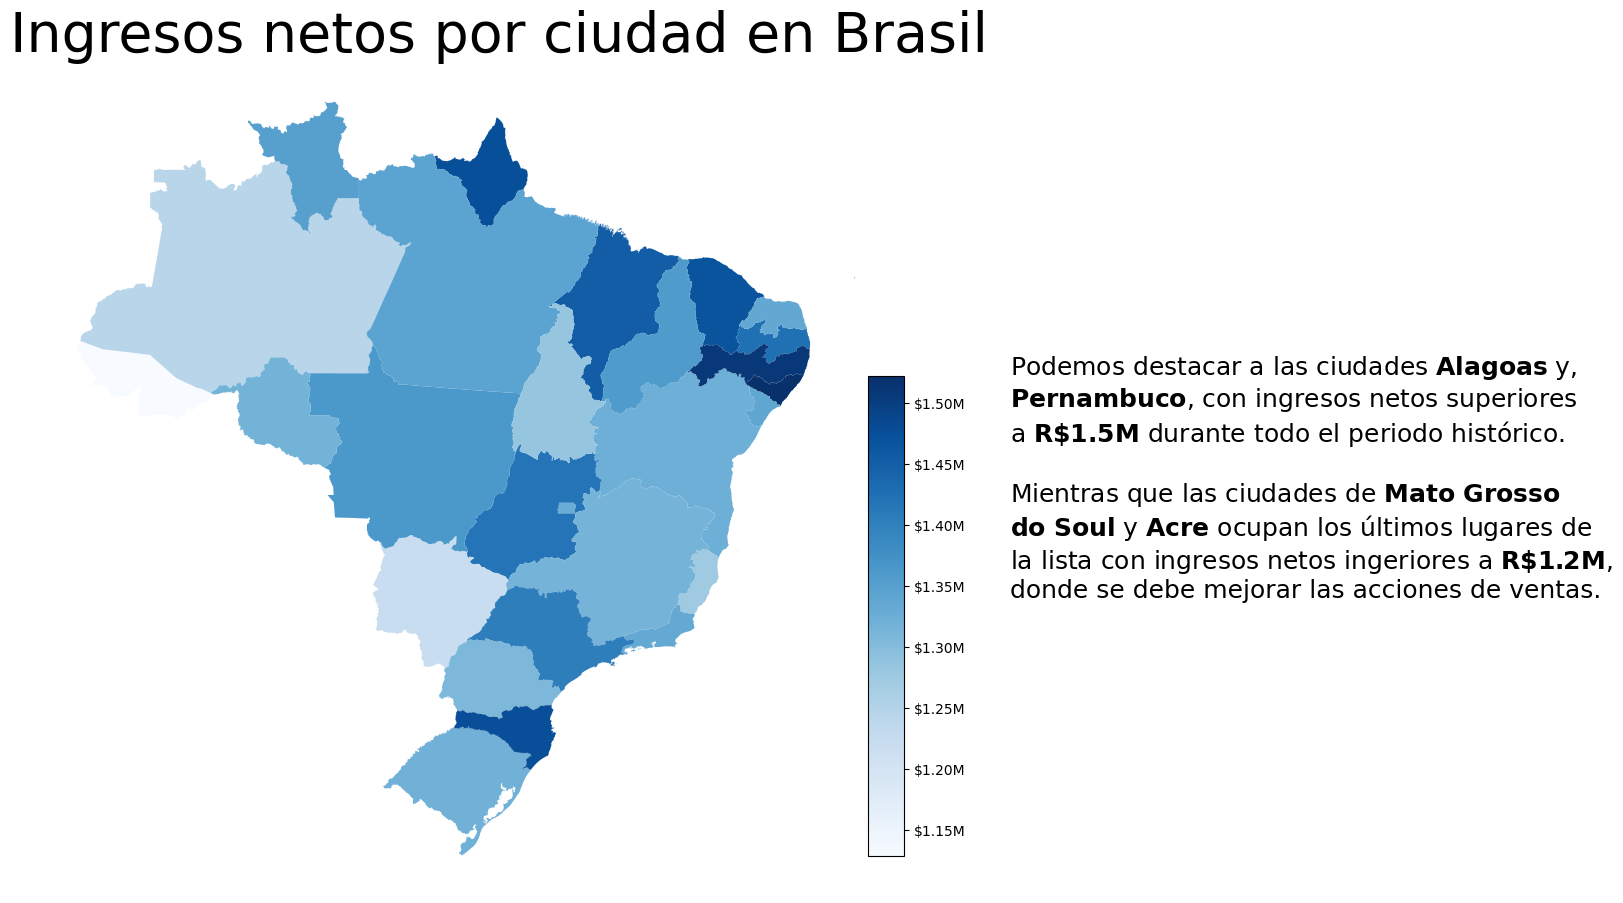

In [48]:
#utilizamos la liberia de geobr para crear un data frame sobre las regiones de brazil
dfbra=geobr.read_state()

br_uf_d=dfbra.merge(df4,on=["abbrev_state"],how='outer')
br_uf_de=br_uf_d[["geometry","ingresos_netos"]]


# Crear la figura y los objetos de ejes
fig, ax = plt.subplots(figsize=(12, 12))

ax=br_uf_de.plot(ax=ax,column="ingresos_netos",cmap="Blues")

cax = fig.add_axes(
    [
        0.82,    # posicao x (entre 0.0 e 1.0)
        0.18,    # posicao y (entre 0.0 e 1.0)
        0.03,    # largura x
        0.40,    # altura y
    ]
)

sm = plt.cm.ScalarMappable(
    cmap="Blues",                                       # Usa o mesmo cmap do mapa
    norm=plt.Normalize(
        vmin=br_uf_de["ingresos_netos"].min(),  # Valor mínimo
        vmax=br_uf_de["ingresos_netos"].max(),  # Valor máximo
    ),
)
fig.colorbar( sm,
    cax=cax,
    # Formata a escala do Colorbar
    format=ticker.FuncFormatter(lambda x, _: f'${x / 1000000:.2f}M'),)

# Quitar la cuadrícula del fondo
ax.grid(False)

# Quitar el cuadro delimitador
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)


# Eliminar etiquetas y ticks del eje y
ax.set_xticklabels([])
ax.tick_params(axis='x', which='both', length=0)
ax.tick_params(axis='y', which='both', length=0)
ax.set_yticklabels([])
# Eliminar el título del eje x
ax.set_xlabel('')

# Eliminar el título del eje y
ax.set_ylabel('')

# Agregar espacio a la derecha del gráfico para el texto "lorem ipsum"
fig.subplots_adjust(right=0.9)  # Ajusta el valor según el espacio deseado


#AGREGA EL TITULO
ax.set_title(
    "Ingresos netos por ciudad en Brasil",
    fontdict={"fontsize": 40},
)

# Obtener límites del eje x y eje y
x_limits = ax.get_xlim()
y_limits = ax.get_ylim()


conclusion_text=(
    "Podemos destacar a las ciudades $\\bf{Alagoas}$ y,\n"
    "$\\bf{Pernambuco}$, con ingresos netos superiores\n"
    "a $\\bf{R \\$1.5M}$ durante todo el periodo histórico.\n\n"
    
    "Mientras que las ciudades de $\\bf{Mato\\ Grosso}$\n"
    "$\\bf{do\\ Soul}$ y $\\bf{Acre}$ ocupan los últimos lugares de\n"
    "la lista con ingresos netos ingeriores a $\\bf{R \\$1.2M}$,\n"
    "donde se debe mejorar las acciones de ventas."

    )
# Añadir texto adicional debajo de la línea
ax.text(x_limits[1] + (x_limits[1] - x_limits[0]) * 0.05,
         (y_limits[0] + y_limits[1]) / 2,
         conclusion_text,
         fontsize=18,
         ha='left',  # Alinear a la izquierda horizontalmente
         va='center')  # Centrar verticalmente




plt.show()


In [49]:
query='''
    SELECT ip.ciudad,
    SUM(total-costo_envio) AS ingresos_netos,
    SUBSTRING(ciudad,4,4) AS abbrev_state,
    SUM(cantidad) AS cantidad_vendida
 
    FROM itens_pedidos  ip
   
    INNER JOIN pedidos ped ON ped.pedido_id=ip.pedido_id
   

    GROUP BY ciudad
    ORDER BY ingresos_netos DESC
    
    '''

df_extra=pd.read_sql(sql=text(query),con=database.connect())
database.dispose()

## **Pregunta 4.1: ¿Cuáles son las cinco regiones que generaron menores ingresos netos? (insight extra)**

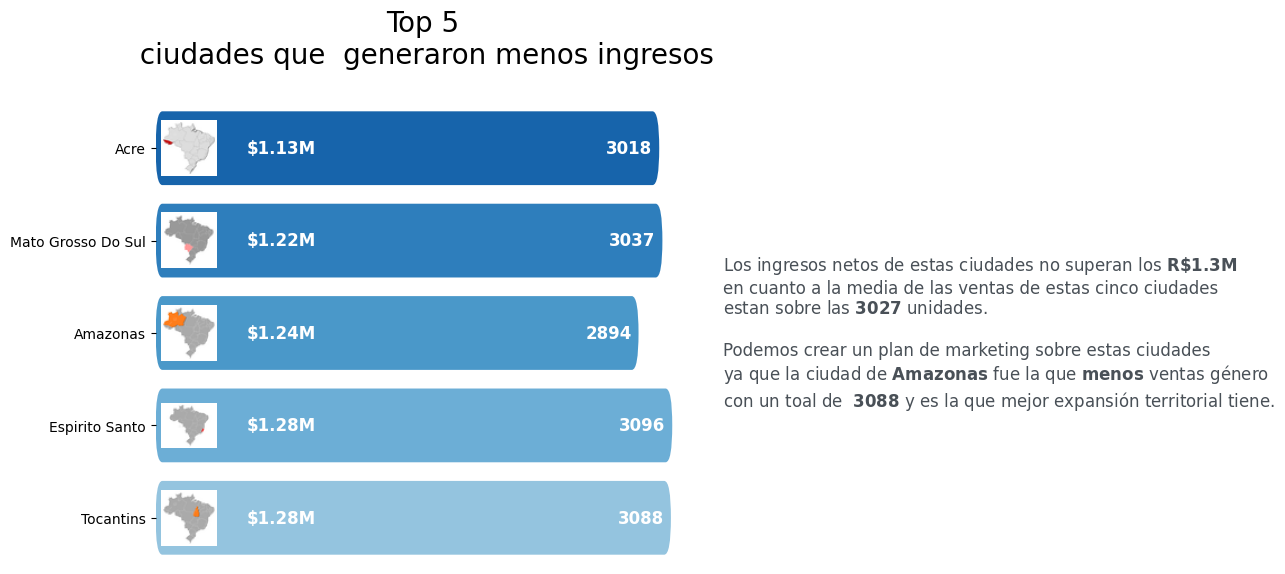

In [50]:
cd_bra_ven=dfbra.merge(df_extra,on=["abbrev_state"],how='outer')[["ingresos_netos","cantidad_vendida","name_state","name_region"]]
cd_bra_ven=cd_bra_ven.sort_values(by="ingresos_netos").head(5)

cd_bra_ven["ingresos_netos"]=(cd_bra_ven["ingresos_netos"]/1000000).apply(lambda x:f'${x:.2f}M')
#generan las figuras
imagenes_paths=[ 'https://i.postimg.cc/fLQt8CrM/acre.png',
                'https://i.postimg.cc/gjHRbS0H/mato.png',
                'https://i.postimg.cc/J7x2b2sc/amazonas1.png',
                'https://i.postimg.cc/15h8wC13/espirito.png',
                'https://i.postimg.cc/9fSj7QNw/tocatins.png']



plt.subplots(figsize=(7,6))
colores_azules=plt.cm.Blues_r(np.linspace(0.2,0.6,len(cd_bra_ven)))
ax=sns.barplot(x=cd_bra_ven.cantidad_vendida/20,y=cd_bra_ven.name_state,orient='h',joinstyle='bevel')
new_patches=[]


for patch,color,name_state,cantidad_vendida,ingresos_netos,image_path in zip(ax.patches,colores_azules,cd_bra_ven["name_state"],cd_bra_ven["cantidad_vendida"],cd_bra_ven["ingresos_netos"],imagenes_paths):
    bb = patch.get_bbox()
   
    p_bbox = FancyBboxPatch((bb.xmin, bb.ymin),
                            abs(bb.width), abs(bb.height),
                            boxstyle="round,pad=-0.0040,rounding_size=2",
                            ec="none", fc=color,
                            mutation_aspect=0.2
                            )
    patch.remove()
    new_patches.append(p_bbox)

    #añadir imagen a la barra 
    response=requests.get(image_path)
    image=plt.imread(BytesIO(response.content))
    imagebox=OffsetImage(image,zoom=0.8)
    ab=AnnotationBbox(imagebox,xy=(10,patch.get_y()+patch.get_height()/2),
                    xybox=(0,0),xycoords="data",boxcoords="offset points",
                    pad=0,arrowprops=dict(arrowstyle='-',color='none'),
                    bboxprops=dict(facecolor='none',edgecolor='none'))
                    
    ax.add_artist(ab)

    #añadir TEXTO cantidad vendida A LADO DE LA derecho DE LA BARRA
    ax.annotate(f'{cantidad_vendida}',xy=(patch.get_width(),patch.get_y()+patch.get_height()/2),
                xytext=(-5,0),textcoords='offset points',
                color='white',fontweight='bold',fontsize=12,ha='right',va='center',
                xycoords='data',
                bbox=dict(facecolor='none',edgecolor='none',pad=0),
                annotation_clip=False)

    #añadir texto total_vendido a lado izquierdo de la barra 

    ax.annotate(f'{ingresos_netos}',xy=(50,patch.get_y()+patch.get_height()/2),
                xytext=(-5,0),textcoords='offset points',
                arrowprops=dict(arrowstyle='-',color='none'),
                color='white',fontweight='bold',fontsize=12,ha='right',va='center',
                xycoords='data',
                bbox=dict(facecolor='none',edgecolor='none',pad=0),
                annotation_clip=False)

for patch in new_patches:
    ax.add_patch(patch)


#agregar concluiusioon a la derecga del grafico 

conclusion_text=(
    "Los ingresos netos de estas ciudades no superan los $\\bf{R \\$1.3M}$ \n"
    "en cuanto a la media de las ventas de estas cinco ciudades\n"
    "estan sobre las $\\bf{3027}$ unidades.\n\n"
    "Podemos crear un plan de marketing sobre estas ciudades\n"
    "ya que la ciudad de $\\bf{Amazonas}$ fue la que $\\bf{menos}$ ventas género\n"
    "con un toal de  $\\bf{3088}$ y es la que mejor expansión territorial tiene."

)

ax.text(170,2,conclusion_text,fontsize=12,color='#495057',va='center',ha='left')

#Personalizando el grafico
ax.set_title("Top 5 \n ciudades que  generaron menos ingresos \n ", loc="center",fontdict={"fontsize":20},pad=0)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([])
ax.yaxis.grid(False)
ax.xaxis.grid(False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
sns.despine(left=True, bottom=True)


plt.show()


# Conclusión

 El análisis de ventas de una región es esencial para el éxito de cualquier negocio. Proporciona información valiosa para la toma de decisiones, la identificación de oportunidades y la optimización de estrategias. Al evaluar las ventas regionales, se pueden adaptar tácticas de marketing, segmentar clientes, medir el rendimiento y anticipar tendencias. En resumen, el análisis de ventas de una región es una herramienta clave para comprender el mercado y lograr un crecimiento sostenible.